<a href="https://colab.research.google.com/github/droyktton/phi4_2D/blob/main/phi4in2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title CUDA C++ code
%%writefile phi4.cu
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/transform.h>
#include <thrust/random.h>
#include <thrust/functional.h>
#include <cmath>
#include <iostream>
#include <fstream>
#include <iomanip>  // <-- required for std::setprecision


const int N = 1024;              // Grid size (NxN)
const int Nsteps = 5000;        // Time steps
const float dt = 0.01f;
const float gamma_ = 1.0f;
const float c = 1.0f;
const float epsilon0 = 1.0f;
const float h = 0.0f;
const float noise_amp = 0.0f;
const float disorder_amp = 0.0f;


void write_field_to_file(const thrust::host_vector<float>& phi_host,
                         int Nx, int Ny, int timestep) {
    std::ofstream file;
    std::string filename = "phi_t" + std::to_string(timestep) + ".dat";
    file.open(filename);

    file << std::fixed << std::setprecision(6);  // Optional: formatting

    for (int j = 0; j < Ny; ++j) {
        for (int i = 0; i < Nx; ++i) {
            file << phi_host[j * Nx + i] << " ";
        }
        file << "\n";
    }

    file.close();
}


struct Laplacian2D {
    int N;
    const float* phi;
    __host__ __device__
    float operator()(int idx) const {
        int i = idx / N;
        int j = idx % N;
        int ip = (i + 1) % N, im = (i - 1 + N) % N;
        int jp = (j + 1) % N, jm = (j - 1 + N) % N;
        return phi[im*N + j] + phi[ip*N + j] + phi[i*N + jm] + phi[i*N + jp] - 4.0f * phi[idx];
    }
};

// Nonlinear and noise update
struct PhiUpdate {
    float c, epsilon0, gamma_, dt, h, noise_amp;
    const float* laplace;
    const float* phi_old;
    const float* r_disorder;

    unsigned int seed;
    __host__ __device__
    float operator()(int i) const {
        float phi = phi_old[i];
        float lap = laplace[i];
        float r = r_disorder[i];

        // Gaussian noise generator
        thrust::default_random_engine rng(seed);
        thrust::normal_distribution<float> dist(0.0f, 1.0f);
        rng.discard(i);
        float xi = noise_amp * dist(rng);

        float nonlinear = epsilon0 * ((1.0f + r) * phi - phi * phi * phi);
        float dphi = (c * lap + nonlinear + h + xi) * dt / gamma_;
        return phi + dphi;
    }
};

int main() {
    int size = N * N;
    thrust::device_vector<float> phi(size);
    thrust::device_vector<float> phi_new(size);
    thrust::device_vector<float> r_disorder(size);
    thrust::device_vector<float> laplace(size);

    // Initialize phi randomly in [-1,1]
    thrust::transform(
        thrust::counting_iterator<int>(0),
        thrust::counting_iterator<int>(size),
        phi.begin(),
        [] __host__ __device__ (int n) {
            thrust::default_random_engine rng(1234);
            thrust::uniform_real_distribution<float> dist(-1.0f, 1.0f);
            rng.discard(n);

            int i = n / N;
            int j = n % N;
            bool isborder = (i < 10 || i > N-10 || j < 10 || j > N-10);

            if(isborder) return -1.0f;
            //else return (dist(rng)>0)?(1.0f):(-1.0f);
            else return dist(rng);
        }
    );

    // Initialize disorder r(x,y)
    thrust::transform(
        thrust::counting_iterator<int>(0),
        thrust::counting_iterator<int>(size),
        r_disorder.begin(),
        [] __host__ __device__ (int i) {
            thrust::default_random_engine rng(5678);
            thrust::uniform_real_distribution<float> dist(-disorder_amp, disorder_amp);
            rng.discard(i);
            return dist(rng);
        }
    );

    thrust::host_vector<float> phi_host(size);
    int nprint = 100;

    for (int step = 0; step < Nsteps; ++step) {

        if (step % nprint == 0) {
            thrust::copy(phi.begin(), phi.end(), phi_host.begin());  // No new allocation
            write_field_to_file(phi_host, N, N, step);
        }

        Laplacian2D lap_op{N, thrust::raw_pointer_cast(phi.data())};
        thrust::transform(
            thrust::counting_iterator<int>(0),
            thrust::counting_iterator<int>(size),
            laplace.begin(),
            lap_op
        );

        PhiUpdate update{c, epsilon0, gamma_, dt, h, noise_amp,
                         thrust::raw_pointer_cast(laplace.data()),
                         thrust::raw_pointer_cast(phi.data()),
                         thrust::raw_pointer_cast(r_disorder.data()),
                         static_cast<unsigned int>(step * 7919)};

        thrust::transform(
            thrust::counting_iterator<int>(0),
            thrust::counting_iterator<int>(size),
            phi_new.begin(),
            update
        );

        // Swap pointers
        thrust::swap(phi, phi_new);
    }

    // Optional: copy to host and save
    thrust::host_vector<float> result = phi;
    // Save result here if needed...

    std::cout << "Simulation complete.\n";
    return 0;
}


Writing phi4.cu


In [2]:
!nvcc --extended-lambda -arch=sm_75 phi4.cu

# Simulation

In [3]:
!./a.out

Simulation complete.


# Results

Miremos primero que pasa a tiempos cortos

## $t=100$

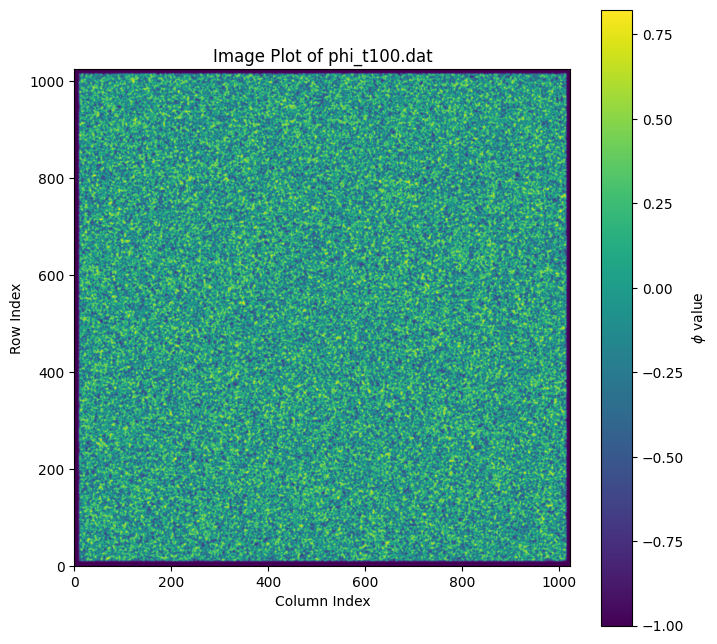

In [6]:
# prompt: plot phi_txxxx.dat matrix data as image plot

import numpy as np
import matplotlib.pyplot as plt

# Load the data from the file
file_path = 'phi_t100.dat'
data = np.loadtxt(file_path)

# Determine the dimensions of the matrix
n_rows, n_cols = data.shape

# Plot the data as an image
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='viridis', origin='lower', extent=[0, n_cols, 0, n_rows])
plt.colorbar(label='$\phi$ value')
plt.title(f'Image Plot of {file_path}')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


Seguramente no estan bien formados los dominios. Veamos el histograma de magnetizacion.

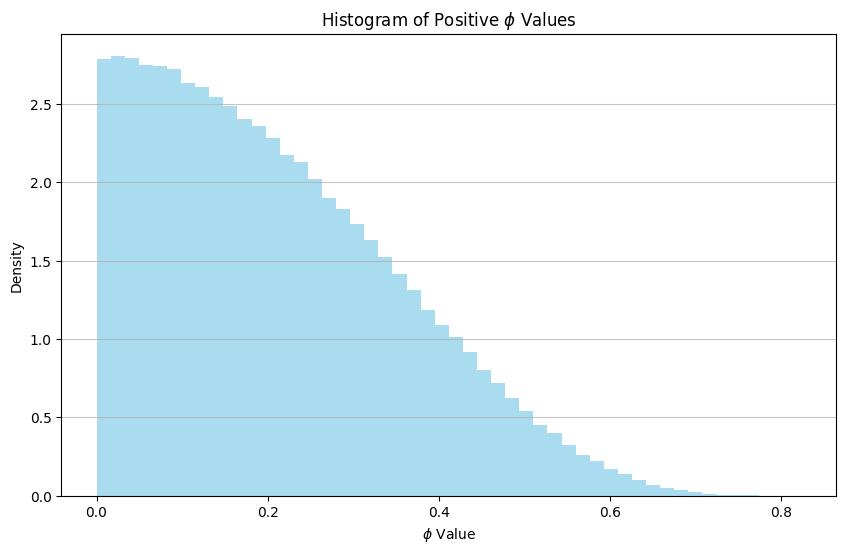

In [5]:
# prompt: make the histogram of positive areas

import matplotlib.pyplot as plt
# Find positive values
positive_areas = data[data > 0]

# Plot histogram of positive values
plt.figure(figsize=(10, 6))
plt.hist(positive_areas.flatten(), bins=50, density=True, alpha=0.7, color='skyblue')
plt.title('Histogram of Positive $\phi$ Values')
plt.xlabel('$\phi$ Value')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)
plt.show()

Efectivamente, no estan bien formados los dominios. Pero, podemos igual mirar los loops donde $\phi(x,y)=0$, binarizado

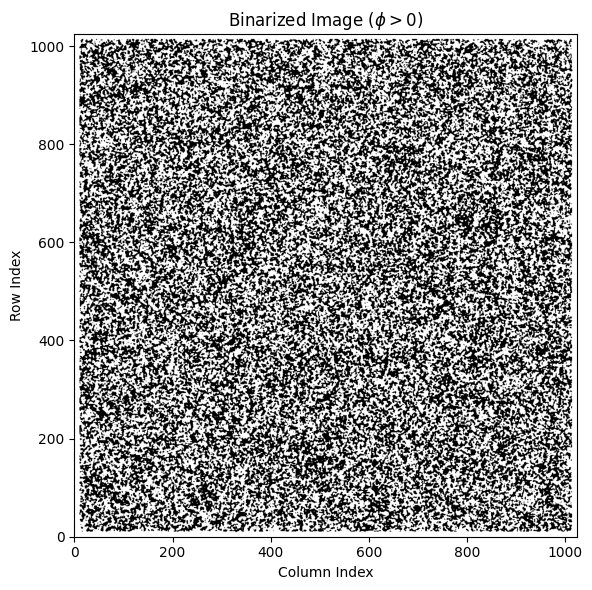

In [9]:
# prompt: Plot binarized image phi>0 and phi<0

import matplotlib.pyplot as plt
import numpy as np
# Create binarized images
phi_positive = np.where(data > 0, 1, 0)
phi_negative = np.where(data < -0, 1, 0)

# Plot binarized images
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.imshow(phi_positive, cmap='binary', origin='lower', extent=[0, n_cols, 0, n_rows])
plt.title('Binarized Image ($\phi > 0$)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

#plt.subplot(1, 2, 2)
#plt.imshow(phi_negative, cmap='binary', origin='lower', extent=[0, n_cols, 0, n_rows])
#plt.title('Binarized Image ($\phi < 0$)')
#plt.xlabel('Column Index')
#plt.ylabel('Row Index')

plt.tight_layout()
plt.show()


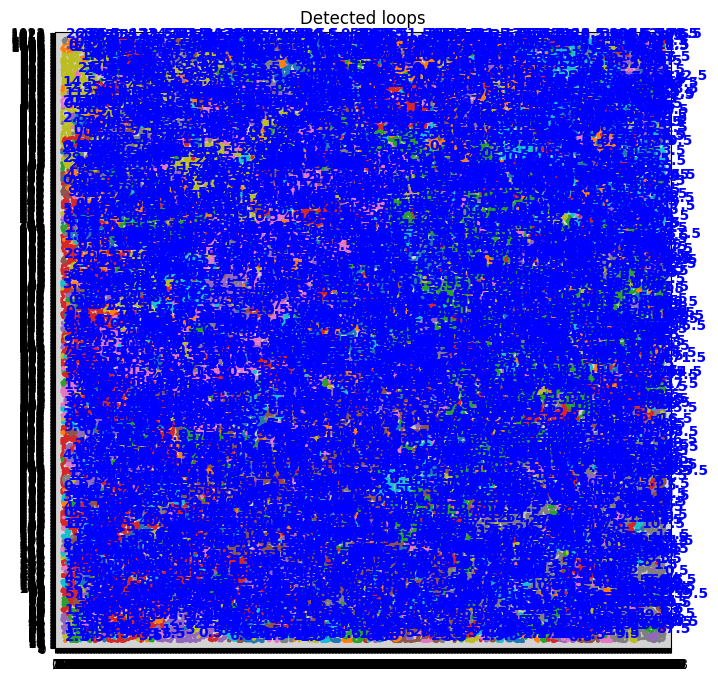

Areas of detected loops:
Loop 1: Area = 905.50
Loop 2: Area = 2.50
Loop 3: Area = 992.50
Loop 4: Area = 63381.50
Loop 5: Area = 2222.50
Loop 6: Area = 32.50
Loop 7: Area = 19.50
Loop 8: Area = 89.50
Loop 9: Area = 376.50
Loop 10: Area = 50.50
Loop 11: Area = 264.50
Loop 12: Area = 61.50
Loop 13: Area = 491.50
Loop 14: Area = 6.50
Loop 15: Area = 7.50
Loop 16: Area = 10325.50
Loop 17: Area = 25.50
Loop 18: Area = 5.50
Loop 19: Area = 71.50
Loop 20: Area = 142.50
Loop 21: Area = 225.50
Loop 22: Area = 17.50
Loop 23: Area = 1090.50
Loop 24: Area = 23.50
Loop 25: Area = 675.50
Loop 26: Area = 192.50
Loop 27: Area = 235.50
Loop 28: Area = 54338.50
Loop 29: Area = 165.50
Loop 30: Area = 0.50
Loop 31: Area = 6.50
Loop 32: Area = 9.50
Loop 33: Area = 17.50
Loop 34: Area = 87.50
Loop 35: Area = 42.50
Loop 36: Area = 6.50
Loop 37: Area = 171.50
Loop 38: Area = 12.50
Loop 39: Area = 1.50
Loop 40: Area = 7.50
Loop 41: Area = 34.50
Loop 42: Area = 186.50
Loop 43: Area = 56.50
Loop 44: Area = 1.50
L

In [10]:
#@title deteccion de loops
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Example binary matrix with some loops
# binary = np.array([
#     [0,0,0,0,0,0,0,0,0,0,0],
#     [0,1,1,1,1,1,1,1,1,1,0],
#     [0,1,0,0,0,0,0,0,0,1,0],
#     [0,1,0,1,1,1,1,1,0,1,0],
#     [0,1,0,1,0,0,0,1,0,1,0],
#     [0,1,0,1,0,1,0,1,0,1,0],
#     [0,1,0,1,0,0,0,1,0,1,0],
#     [0,1,0,1,1,1,1,1,0,1,0],
#     [0,1,0,0,0,0,0,0,0,1,0],
#     [0,1,1,1,1,1,1,1,1,1,0],
#     [0,0,0,0,0,0,0,0,0,0,0],
# ])

binary = phi_positive

# Detect contours (loops) at the 0.5 level to separate 0 and 1
contours = measure.find_contours(binary, 0.5)

areas = []
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(binary, cmap='gray_r')
ax.set_title("Detected loops")

for i, contour in enumerate(contours):
    x, y = contour[:, 1], contour[:, 0]
    # Compute polygon area using shoelace formula
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    areas.append(area)

    ax.plot(x, y, linewidth=2)
    # Annotate area on the plot near the start of the contour
    ix, iy = int(round(x[0])), int(round(y[0]))
    ax.text(ix, iy, f"{area:.1f}", color='blue', fontsize=10, weight='bold')

ax.set_xticks(np.arange(binary.shape[1]))
ax.set_yticks(np.arange(binary.shape[0]))
ax.grid(True, color='lightgray', linewidth=0.5)
ax.invert_yaxis()

plt.show()

# Print areas
print("Areas of detected loops:")
for i, area in enumerate(areas):
    print(f"Loop {i+1}: Area = {area:.2f}")



Veamos el histograma de areas de todos los loops

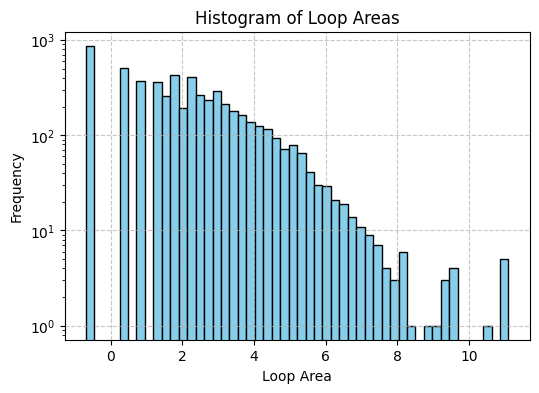

In [11]:
# Plot histogram of loop areas
plt.figure(figsize=(6,4))
plt.hist(np.log(areas), bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Loop Area")
plt.ylabel("Frequency")
plt.title("Histogram of Loop Areas")
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xscale('log')
plt.yscale('log')
plt.show()


y ahora su distribucion cumulada

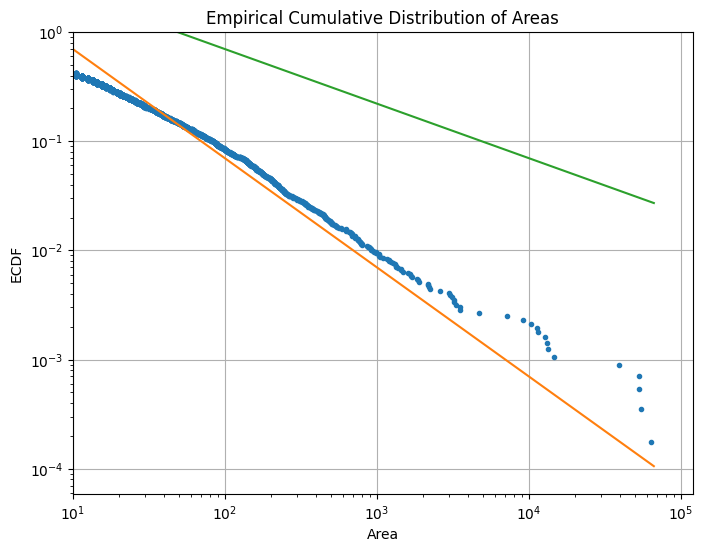

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'areas' is your array of data
# Example data (replace with your actual 'areas' array)
#areas = np.random.rand(100) * 100

# Sort the areas
areas_sorted = np.sort(areas)

# Calculate the cumulative probabilities
n = len(areas_sorted)
cumulative_probabilities = np.arange(1, n + 1) / n

# Plot the Empirical Cumulative Distribution
plt.figure(figsize=(8, 6))
plt.plot(areas_sorted, 1.0-cumulative_probabilities, marker='.', linestyle='none')
plt.plot(areas_sorted, 7./areas_sorted**1.0, linestyle='-')
plt.plot(areas_sorted, 7./areas_sorted**0.5, linestyle='-')

plt.title('Empirical Cumulative Distribution of Areas')
plt.xlabel('Area')
plt.ylabel('ECDF')
plt.grid(True)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=10)
plt.ylim(top=1)

plt.show()

Este resultado es my conocido de teoria de percolacion, $1-F(a) \sim 1/a$.

## $t=1000$

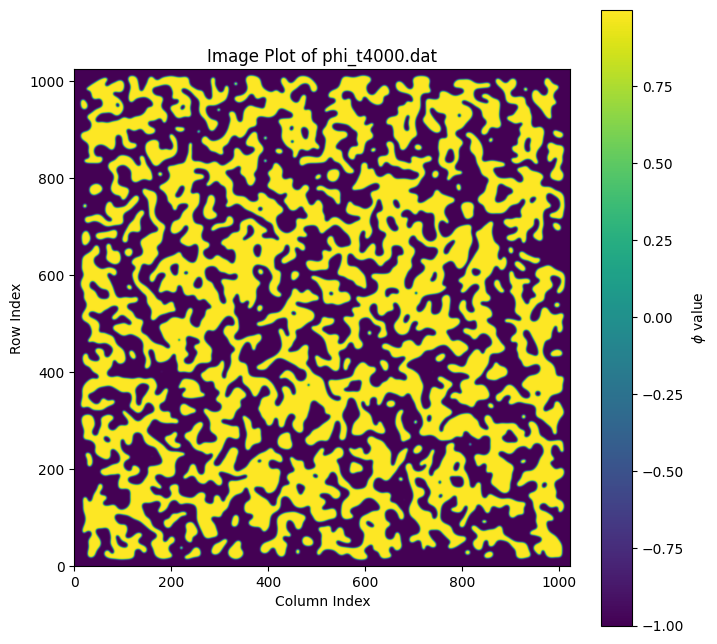

In [33]:
# prompt: plot phi_txxxx.dat matrix data as image plot

import numpy as np
import matplotlib.pyplot as plt

# Load the data from the file
file_path = 'phi_t4000.dat'
data = np.loadtxt(file_path)

# Determine the dimensions of the matrix
n_rows, n_cols = data.shape

# Plot the data as an image
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='viridis', origin='lower', extent=[0, n_cols, 0, n_rows])
plt.colorbar(label='$\phi$ value')
plt.title(f'Image Plot of {file_path}')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


Seguramente no estan bien formados los dominios. Veamos el histograma de magnetizacion.

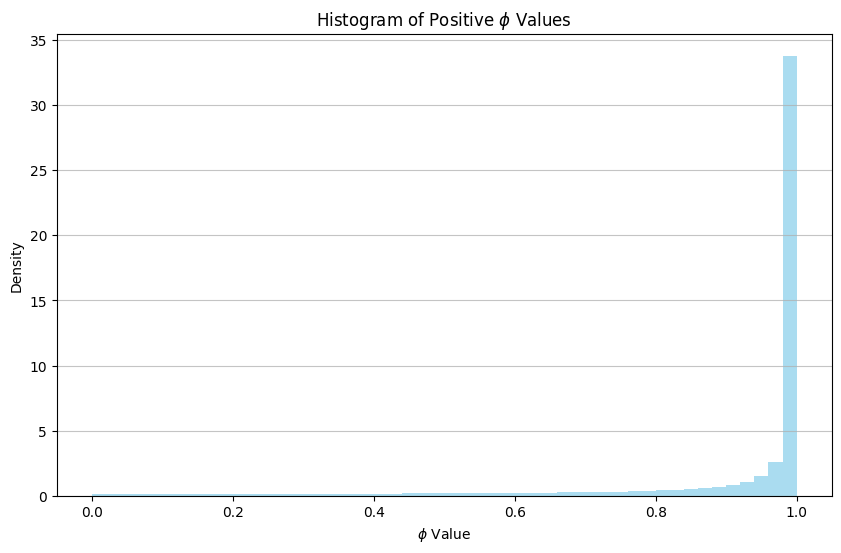

In [34]:
# prompt: make the histogram of positive areas

import matplotlib.pyplot as plt
# Find positive values
positive_areas = data[data > 0]

# Plot histogram of positive values
plt.figure(figsize=(10, 6))
plt.hist(positive_areas.flatten(), bins=50, density=True, alpha=0.7, color='skyblue')
plt.title('Histogram of Positive $\phi$ Values')
plt.xlabel('$\phi$ Value')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)
plt.show()

Efectivamente, ahora si estan bien formados los dominios.

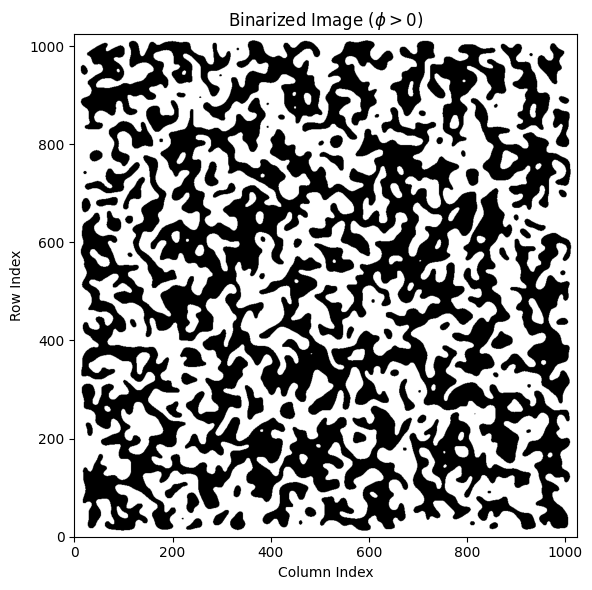

In [35]:
# prompt: Plot binarized image phi>0 and phi<0

import matplotlib.pyplot as plt
import numpy as np
# Create binarized images
phi_positive = np.where(data > 0, 1, 0)
phi_negative = np.where(data < -0, 1, 0)

# Plot binarized images
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.imshow(phi_positive, cmap='binary', origin='lower', extent=[0, n_cols, 0, n_rows])
plt.title('Binarized Image ($\phi > 0$)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

#plt.subplot(1, 2, 2)
#plt.imshow(phi_negative, cmap='binary', origin='lower', extent=[0, n_cols, 0, n_rows])
#plt.title('Binarized Image ($\phi < 0$)')
#plt.xlabel('Column Index')
#plt.ylabel('Row Index')

plt.tight_layout()
plt.show()


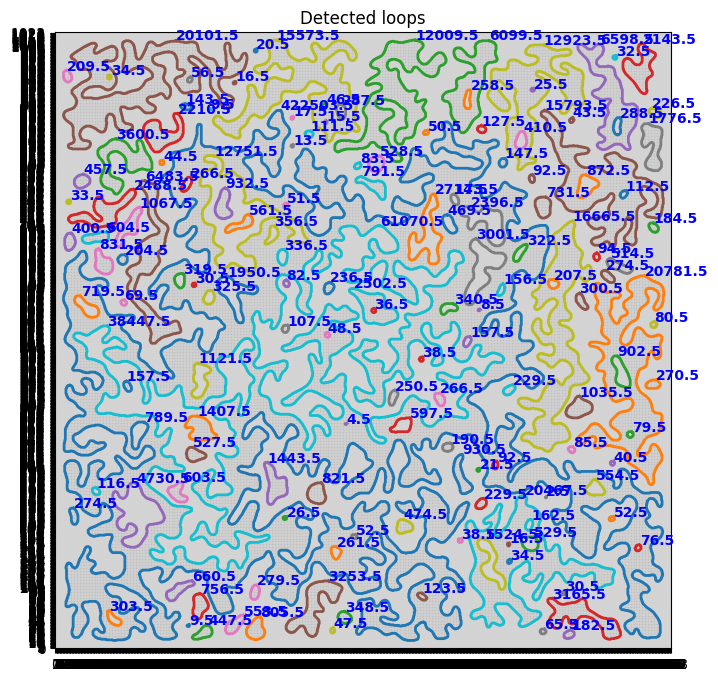

Areas of detected loops:
Loop 1: Area = 422503.50
Loop 2: Area = 805.50
Loop 3: Area = 447.50
Loop 4: Area = 3165.50
Loop 5: Area = 182.50
Loop 6: Area = 3253.50
Loop 7: Area = 553.50
Loop 8: Area = 65.50
Loop 9: Area = 47.50
Loop 10: Area = 20467.50
Loop 11: Area = 9.50
Loop 12: Area = 303.50
Loop 13: Area = 348.50
Loop 14: Area = 756.50
Loop 15: Area = 660.50
Loop 16: Area = 123.50
Loop 17: Area = 279.50
Loop 18: Area = 30.50
Loop 19: Area = 1524.50
Loop 20: Area = 38447.50
Loop 21: Area = 34.50
Loop 22: Area = 261.50
Loop 23: Area = 529.50
Loop 24: Area = 76.50
Loop 25: Area = 4730.50
Loop 26: Area = 16.50
Loop 27: Area = 38.50
Loop 28: Area = 52.50
Loop 29: Area = 474.50
Loop 30: Area = 162.50
Loop 31: Area = 274.50
Loop 32: Area = 52.50
Loop 33: Area = 26.50
Loop 34: Area = 229.50
Loop 35: Area = 1443.50
Loop 36: Area = 821.50
Loop 37: Area = 603.50
Loop 38: Area = 2.50
Loop 39: Area = 554.50
Loop 40: Area = 116.50
Loop 41: Area = 930.50
Loop 42: Area = 20781.50
Loop 43: Area = 21

In [36]:
#@title deteccion de loops
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Example binary matrix with some loops
# binary = np.array([
#     [0,0,0,0,0,0,0,0,0,0,0],
#     [0,1,1,1,1,1,1,1,1,1,0],
#     [0,1,0,0,0,0,0,0,0,1,0],
#     [0,1,0,1,1,1,1,1,0,1,0],
#     [0,1,0,1,0,0,0,1,0,1,0],
#     [0,1,0,1,0,1,0,1,0,1,0],
#     [0,1,0,1,0,0,0,1,0,1,0],
#     [0,1,0,1,1,1,1,1,0,1,0],
#     [0,1,0,0,0,0,0,0,0,1,0],
#     [0,1,1,1,1,1,1,1,1,1,0],
#     [0,0,0,0,0,0,0,0,0,0,0],
# ])

binary = phi_positive

# Detect contours (loops) at the 0.5 level to separate 0 and 1
contours = measure.find_contours(binary, 0.5)

areas = []
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(binary, cmap='gray_r')
ax.set_title("Detected loops")

for i, contour in enumerate(contours):
    x, y = contour[:, 1], contour[:, 0]
    # Compute polygon area using shoelace formula
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    areas.append(area)

    ax.plot(x, y, linewidth=2)
    # Annotate area on the plot near the start of the contour
    ix, iy = int(round(x[0])), int(round(y[0]))
    ax.text(ix, iy, f"{area:.1f}", color='blue', fontsize=10, weight='bold')

ax.set_xticks(np.arange(binary.shape[1]))
ax.set_yticks(np.arange(binary.shape[0]))
ax.grid(True, color='lightgray', linewidth=0.5)
ax.invert_yaxis()

plt.show()

# Print areas
print("Areas of detected loops:")
for i, area in enumerate(areas):
    print(f"Loop {i+1}: Area = {area:.2f}")



Veamos el histograma de areas de todos los loops

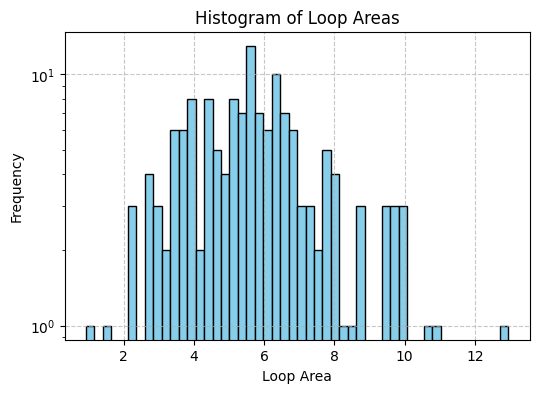

In [37]:
# Plot histogram of loop areas
plt.figure(figsize=(6,4))
plt.hist(np.log(areas), bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Loop Area")
plt.ylabel("Frequency")
plt.title("Histogram of Loop Areas")
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xscale('log')
plt.yscale('log')
plt.show()


Como vemos, ya las areas pequeñas colapsaron.
Veamos ahora su distribucion cumulada




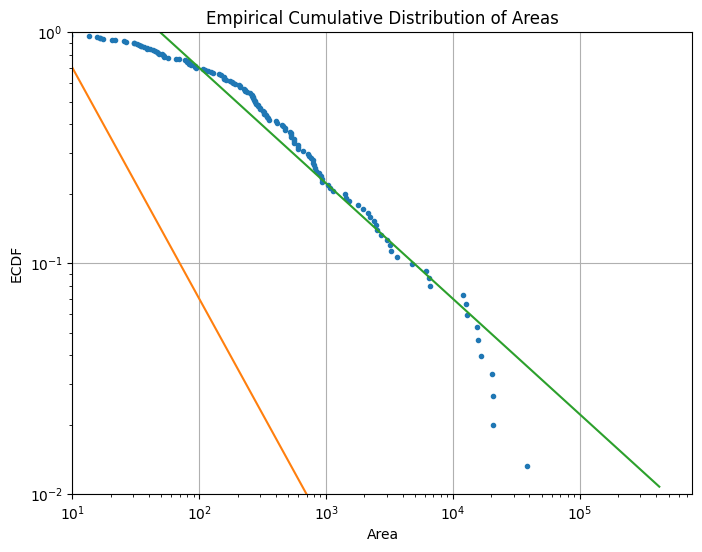

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'areas' is your array of data
# Example data (replace with your actual 'areas' array)
#areas = np.random.rand(100) * 100

# Sort the areas
areas_sorted = np.sort(areas)

# Calculate the cumulative probabilities
n = len(areas_sorted)
cumulative_probabilities = np.arange(1, n + 1) / n

# Plot the Empirical Cumulative Distribution
plt.figure(figsize=(8, 6))
plt.plot(areas_sorted, 1.0-cumulative_probabilities, marker='.', linestyle='none')
plt.plot(areas_sorted, 7./areas_sorted**1.0, linestyle='-')
plt.plot(areas_sorted, 7./areas_sorted**0.5, linestyle='-')

plt.title('Empirical Cumulative Distribution of Areas')
plt.xlabel('Area')
plt.ylabel('ECDF')
plt.grid(True)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=10)
plt.ylim(bottom=0.01,top=1)

plt.show()

Ahora, a diferencia del resultado de percolacion o de grandes areas, $1-F(a) \sim 1/a^{1/2}$.